### Cloudlab

Use the following profile to start an experiment with a dumbell topology on CloudLab: [cloudlab](https://www.cloudlab.us/show-profile.php?profile=e05fa654-f030-11ed-9f39-e4434b2381fc)

Make sure to choose the following hardware options.

- For the end hosts: m400

- For the router node: c6525-25g

Link Capacity of the router: 25000000

#### Router Node Configuration

SSH into the router node and run the following commands to configure the router node.

```bash

#!/bin/bash

router_egress_name=$( ip route get 10.10.2.10 | grep -oP "(?<=dev )[^ ]+" )
router_ingress_name=$( ip route get 10.10.1.10 | grep -oP "(?<=dev )[^ ]+" )

sudo ethtool  -K $router_egress_name hw-tc-offload off
sudo ethtool  -k $router_egress_name | grep hw-tc-offload

sudo tc qdisc del dev $router_ingress_name root
sudo tc qdisc add dev $router_ingress_name root netem delay 10ms limit 10000


sudo tc qdisc del dev $router_egress_name root
sudo tc qdisc add dev $router_egress_name root handle 1: tbf rate 100Mbit burst 50k limit 10000
sudo tc qdisc add dev $router_egress_name parent 1: handle 2: bfifo limit 100kb
```

#### Montioring the Queue

Create a file named `monitor_queue.sh` and paste the following code in it.

```bash
INTERFACE=$( ip route get 10.10.2.10 | grep -oP "(?<=dev )[^ ]+" )
LOG_FILE="backlog.txt"

# Ensure the log file is empty
> $LOG_FILE
> "dropped.txt"
while true; do
    # Get the current date and time
    #echo -n "$(date +'%Y-%m-%d %H:%M:%S'): " >> $LOG_FILE
    Time="$(date +%s.%N)"
    # Fetch the current backlog and append to the log
    queueSize="$Time $(tc -s qdisc show dev $INTERFACE | grep "backlog" | tail -1 | awk '{print $2 " " $3}')"
   dropped="$Time $(tc -s qdisc show dev $INTERFACE | grep "dropped" | tail -1 | awk '{print $7}')"
    echo "$queueSize" >> $LOG_FILE
    echo "$dropped" >> "Dropped.txt"
    # Wait for one second
    sleep 0.00001
done
```

Use the following command to make sure the script is executable.

```bash
chmod +x monitor_queue.sh
```

#### sender and receiver node configuration

Run the following commands on the sender and receiver nodes.

```bash
sudo apt-get update -y
sudo apt-get install -y moreutils
sudo apt-get install iperf3
```


Run the following commands in the sender node to download the script that will be used to collect traffic statistics.
```bash
$  wget -O ss-output.sh https://raw.githubusercontent.com/ffund/tcp-ip-essentials/cloudlab/scripts/ss-output.sh
$  chmod +x ss-output.sh
```


#### iperf Commands

To start the experiment run the following commands in the respective terminals. Follow the order of the commands.

Receiver Terminal
```bash
$  iperf3 -s -1 -f m
```

Sender Terminal 1
```bash
$  bash ss-output.sh 10.10.2.10
```

Router Terminal
```bash
$  bash monitor_queue.sh
```
Sender Terminal 2
```bash
$  iperf3 -V -t 60 -P 1 -c 10.10.2.10 -C cubic
```

#### Retrieving Data

Use the following command to retrieve the data. Fill in the appropirate values for the sender and receiver node usernames and hostnames.

```
$  scp <sender node username>@<sender node hostname>:ss-output.sh <receiver node username>@<receiver node hostname>:backlog_log.txt <receiver node username>@<receiver node hostname>:Dropped.txt ./data
```

#### Plotting Data

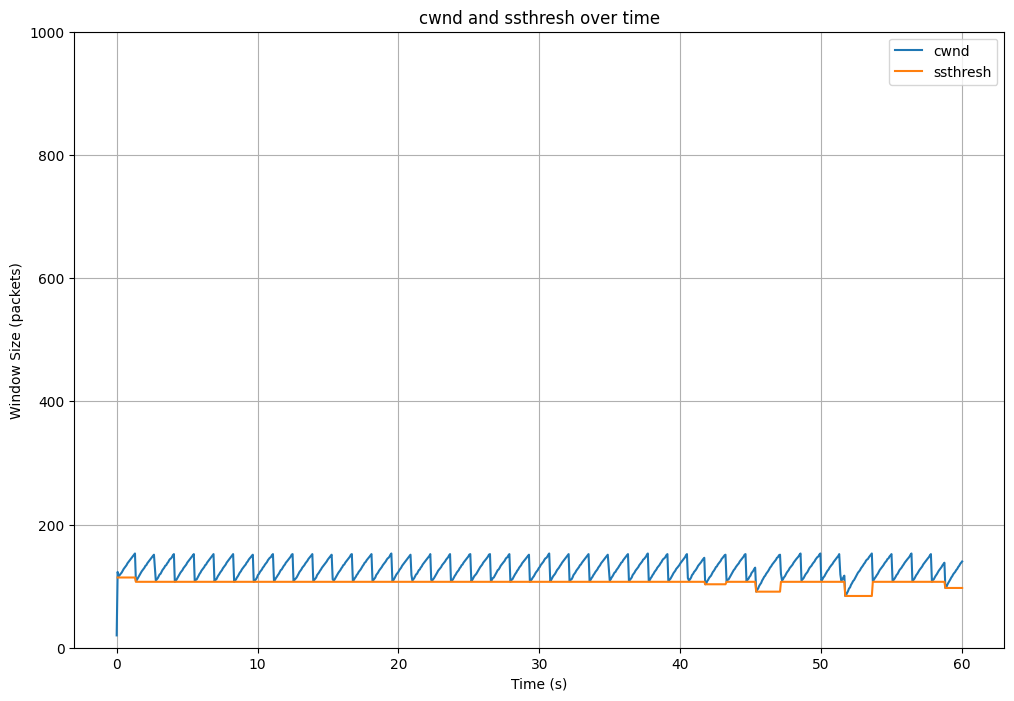

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(f"data/sender-ss.csv", names=['time', 'sender', 'retx_unacked', 'retx_cum', 'cwnd', 'ssthresh', 'rtt'])

# Filter data for a specific sender (replace 'specific_sender' with the actual sender identifier)

df_filtered = df[df['sender'] == df['sender'].value_counts().idxmax()]

time_min = df_filtered.time.min()
cwnd_max = 1.1* df_filtered.cwnd.max()
# Check if there is data for the specific sender
if df_filtered.empty:
    print("No data for the specific sender")
    exit()

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(df_filtered['time']-time_min, df_filtered['cwnd'], label='cwnd')
plt.plot(df_filtered['time']-time_min, df_filtered['ssthresh'], label='ssthresh')
plt.xlabel('Time (s)')
plt.ylabel('Window Size (packets)')
plt.legend()
plt.title('cwnd and ssthresh over time')
plt.ylim(0, 1000)
plt.grid()
plt.savefig('data/sender-ss.png')
plt.show()



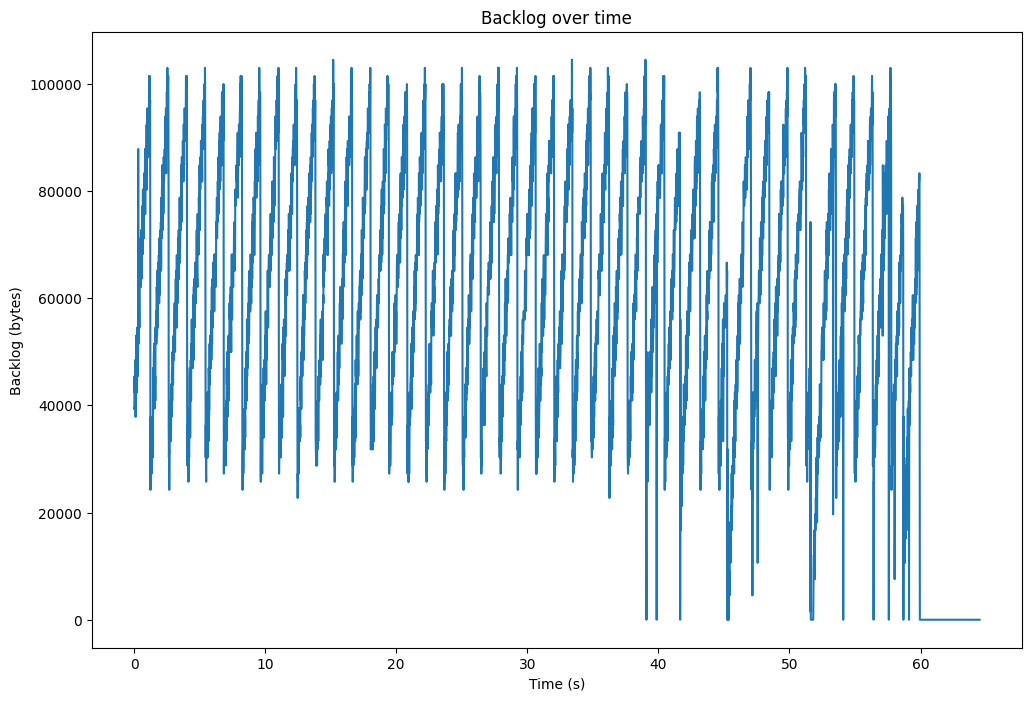

In [2]:
df_backlog = pd.read_csv(f"data/backlog.txt", names = ['time', 'bytes', 'packets'], sep=' ')
df_backlog = df_backlog[df_backlog['time'].astype(float)>time_min]
df_backlog['time'] = df_backlog['time'].astype(float) - time_min
df_backlog['bytes'] = df_backlog['bytes'].str.replace('b','').str.replace('K','000').str.replace('M','000000').astype(int)
df_backlog['packets'] = df_backlog['packets'].str.replace('p','').astype(int)
# df_backlog.head()
plt.figure(figsize=(12, 8))
plt.plot(df_backlog['time'], df_backlog['bytes'])
plt.xlabel("Time (s)")
plt.ylabel("Backlog (bytes)")
plt.title("Backlog over time")
plt.savefig("data/backlog.png")
plt.show()

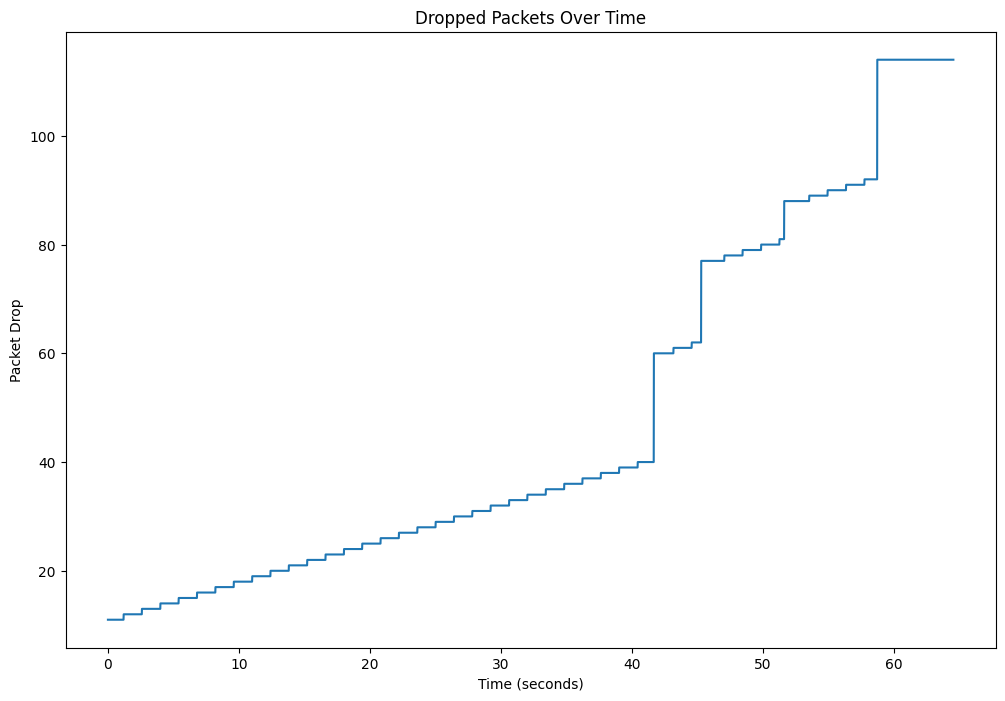

In [3]:
df_qDrop = pd.read_csv(f"data/dropped.txt", sep=r'\s+', header=None, names=['time', 'dropped']).reset_index()
df_qDrop.drop(columns=['index'], inplace=True)
df_qDrop['time'] = df_qDrop['time'].astype(float)

# print(df_qDrop.tail())
df_qDrop = df_qDrop[df_qDrop['time'] >= time_min]
# print(df_qDrop.tail())
df_qDrop['time'] = df_qDrop['time'].apply(lambda x: (x - time_min))  # Convert to seconds
df_qDrop.set_index('time', inplace=True)
df_qDrop['dropped'] = df_qDrop['dropped'].str.replace(',', '').astype(int)

# df_qDrop['drop_change'] = df_qDrop['dropped'].diff().fillna(0).astype(bool)
# filtered = df_qDrop[df_qDrop['drop_change']]

# plt.figure(figsize=(10, 6))
# Plot vertical lines at the points where there is a drop change
# for time in filtered.index:
#     plt.axvline(x=time, color='red', linestyle='--', label='Packet Drop')
plt.figure(figsize=(12, 8))
plt.plot(df_qDrop.index, df_qDrop['dropped'])
# df_qDrop.plot()
plt.xlabel('Time (seconds)')
plt.ylabel('Packet Drop')
plt.title('Dropped Packets Over Time')
# plt.legend()
plt.savefig('data/packet_drop.png')
plt.show();